In [1]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.nanops import bottleneck_switch

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 5  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'urw_stats_10-31-24'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'long_run'

det_single = 'asacusa_strip_1'

# file_nums = list(range(0, 98))
# file_nums = list(range(0, 109))
file_nums = 'all'

noise_sigma = 5

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [3]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 237/237 [00:24<00:00,  9.77it/s]


In [4]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [5]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, save_waveforms=False, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 4
FEU Channels: [5, 6, 7, 8]
HV: {'drift': 800, 'resist_1': 450, 'resist_2': 450}
Reading in data...


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Read in data shape: (217821, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Fitting time: 4.59364652633667 s
Processed sub-chunk 1/1
Processed chunk 1/3


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


Read in data shape: (219796, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Fitting time: 5.101857423782349 s
Processed sub-chunk 1/1
Processed chunk 2/3


100%|██████████| 37/37 [00:07<00:00,  4.66it/s]


Read in data shape: (81718, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:01<00:00, 11.00it/s]


Fitting time: 2.0771732330322266 s
Processed sub-chunk 1/1
Processed chunk 3/3
Getting hits...
Hits shape: (519335, 256)


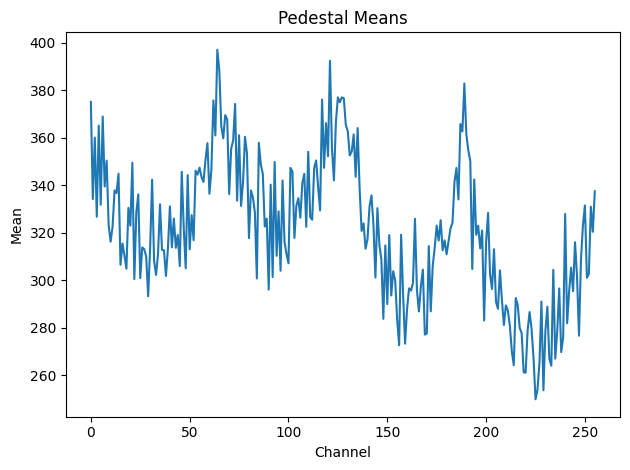

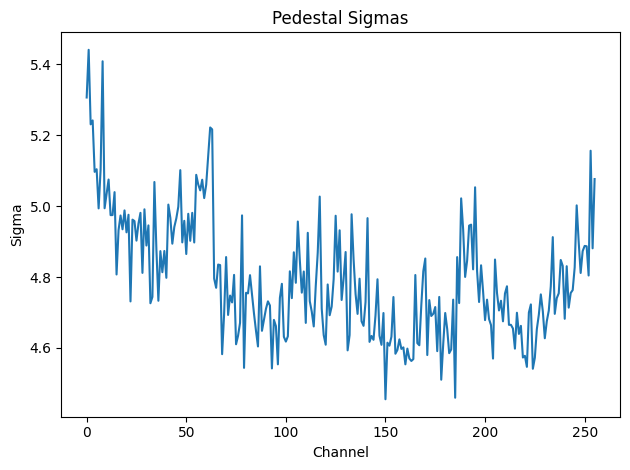

In [6]:
det.dream_data.plot_pedestals()

/home/dylan/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:737: RuntimeWarning: All-NaN slice encountered
  event_max_amps = np.nanmax(self.data_amps, axis=1)


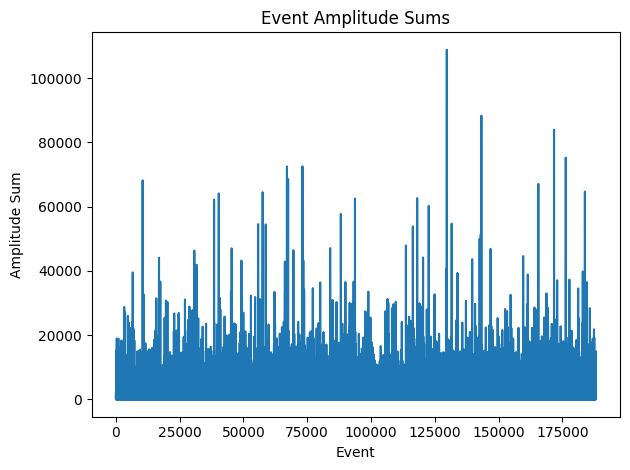

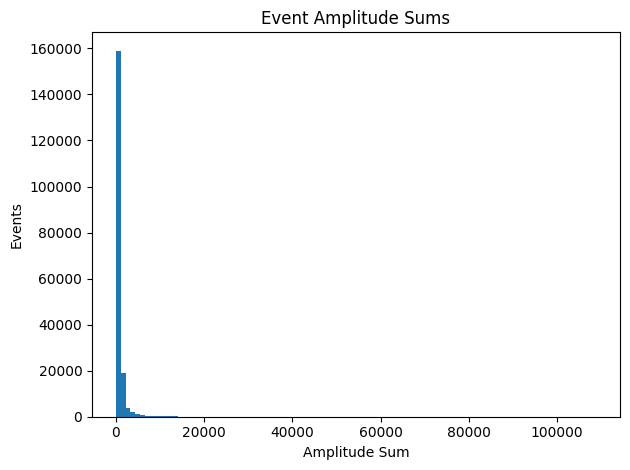

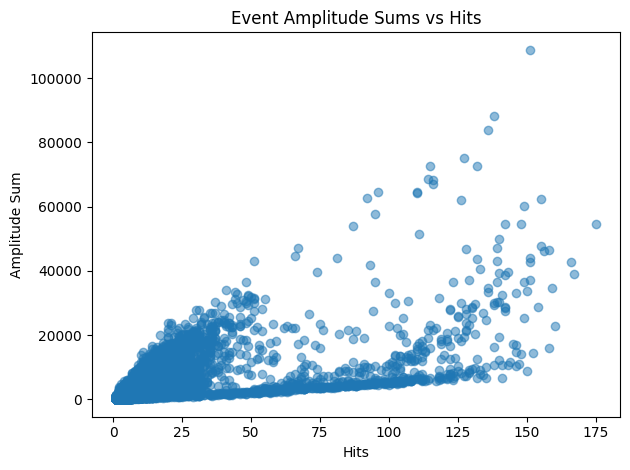

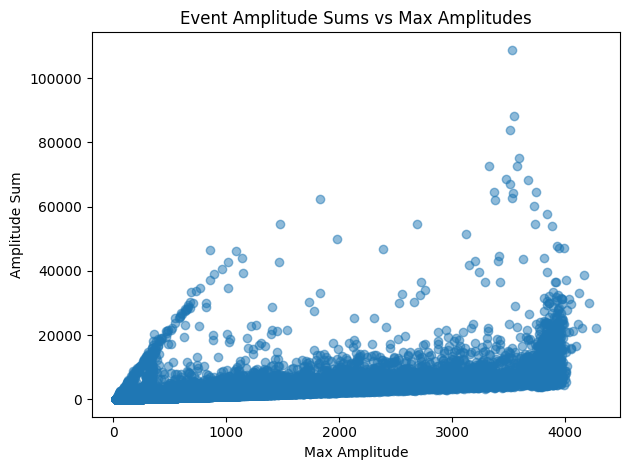

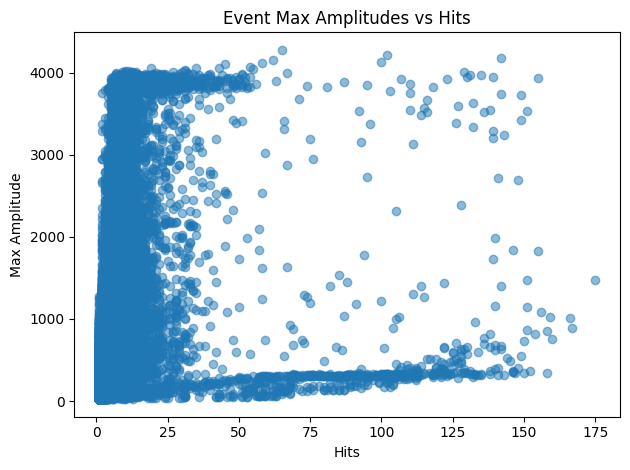

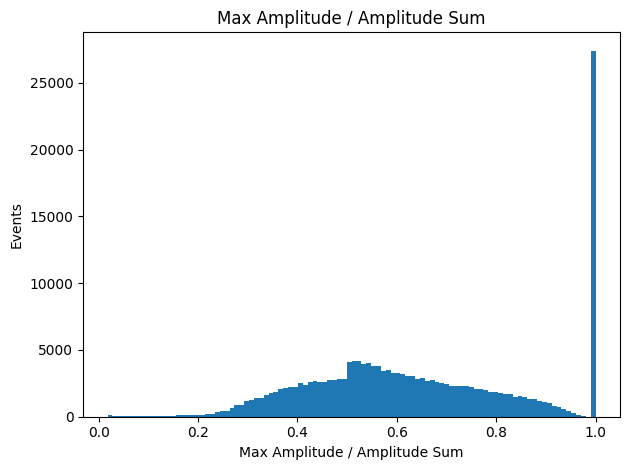

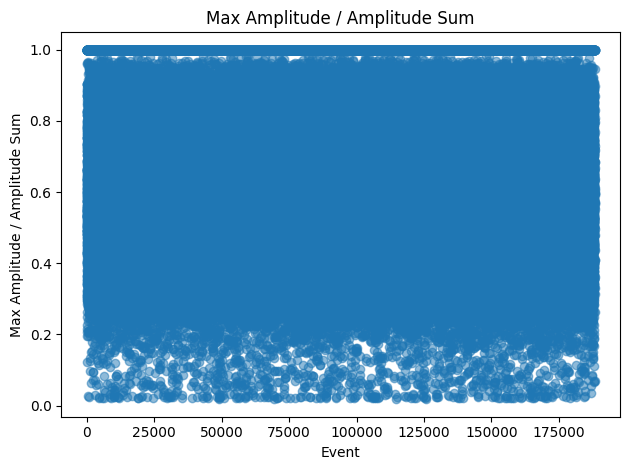

In [7]:
det.dream_data.plot_noise_metric()

Connector 5 Dead Strips: []
Connector 6 Dead Strips: []
Connector 7 Dead Strips: []
Connector 8 Dead Strips: []


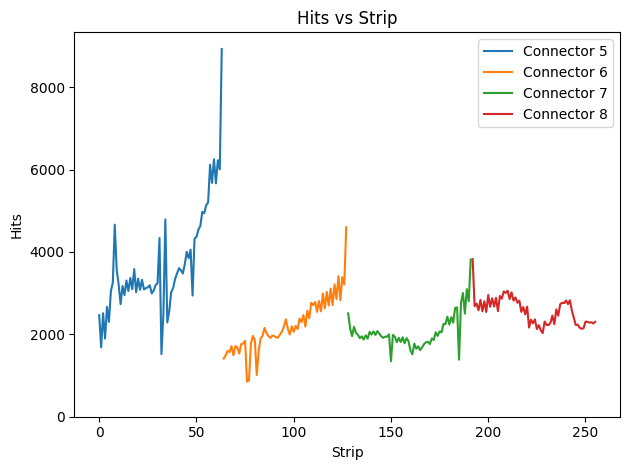

In [8]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

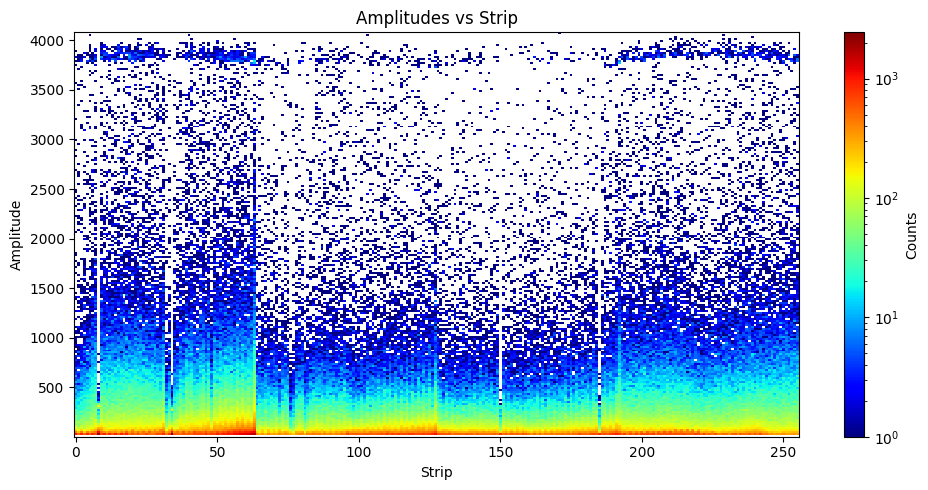

In [9]:
det.dream_data.plot_amplitudes_vs_strip()

/home/dylan/PycharmProjects/saclay_micromegas/Detector_Classes/DreamDetector.py:615: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


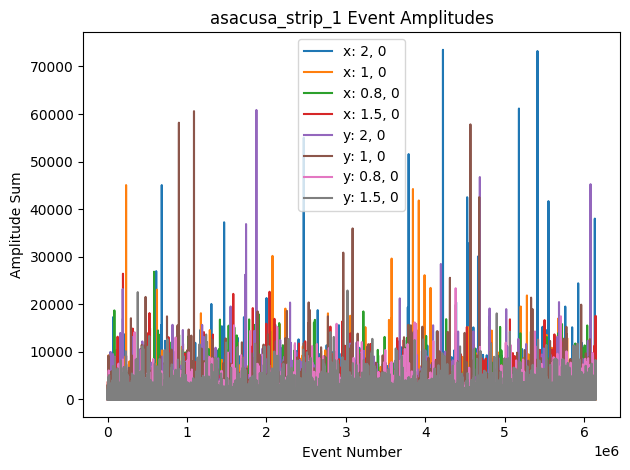

In [10]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.add_rotation(90, 'z')

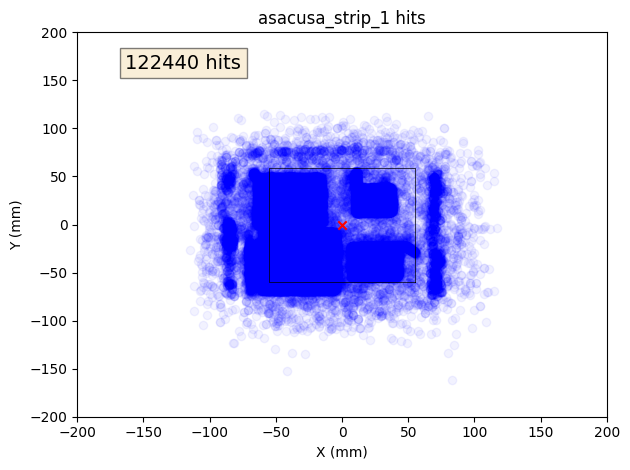

In [11]:
plot_ray_hits_2d(det, ray_data)

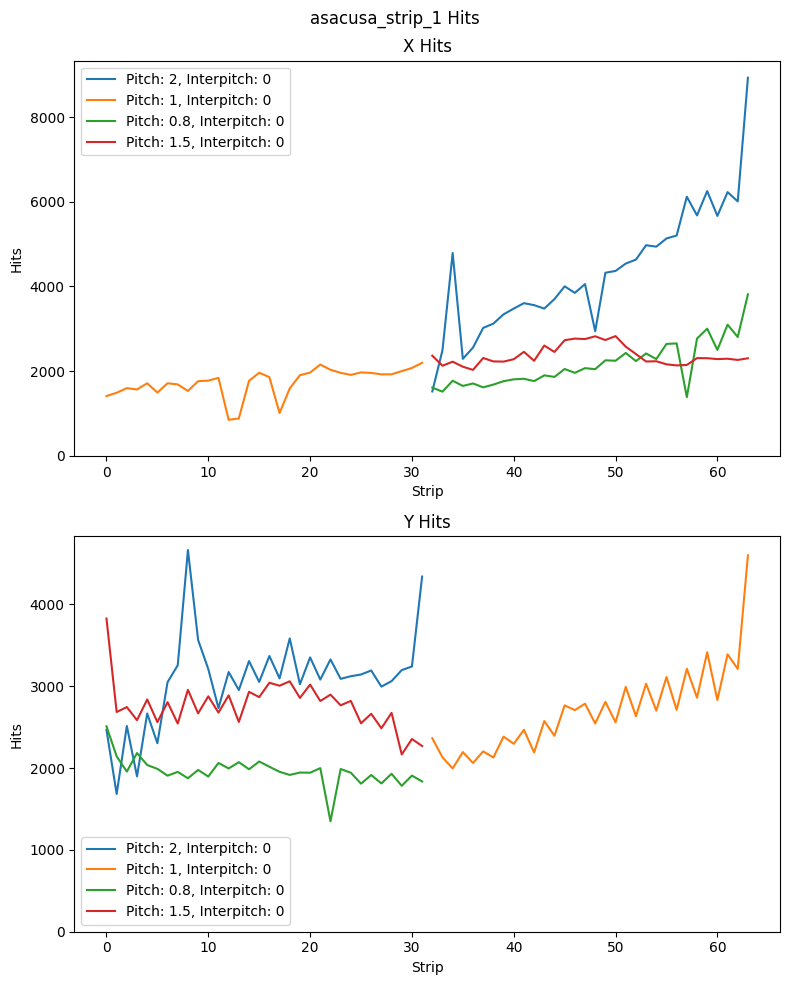

In [12]:
det.plot_hits_1d()

In [13]:
print(len(det.dream_data.hits))

519335


In [14]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

z: 600.0
z: 600.3448275862069
z: 600.6896551724138
z: 601.0344827586207
z: 601.3793103448276
z: 601.7241379310345
z: 602.0689655172414
z: 602.4137931034483
z: 602.7586206896551
z: 603.1034482758621
z: 603.448275862069
z: 603.7931034482758
z: 604.1379310344828
z: 604.4827586206897
z: 604.8275862068965
z: 605.1724137931035
z: 605.5172413793103
z: 605.8620689655172
z: 606.2068965517242
z: 606.551724137931
z: 606.8965517241379
z: 607.2413793103449
z: 607.5862068965517
z: 607.9310344827586
z: 608.2758620689655
z: 608.6206896551724
z: 608.9655172413793
z: 609.3103448275862
z: 609.6551724137931
z: 610.0
z_rot: -1.0
z_rot: -0.9310344827586207
z_rot: -0.8620689655172413
z_rot: -0.7931034482758621
z_rot: -0.7241379310344828
z_rot: -0.6551724137931034
z_rot: -0.5862068965517242
z_rot: -0.5172413793103449
z_rot: -0.4482758620689655
z_rot: -0.3793103448275862
z_rot: -0.31034482758620685
z_rot: -0.24137931034482762
z_rot: -0.1724137931034483
z_rot: -0.10344827586206895
z_rot: -0.034482758620689724
z

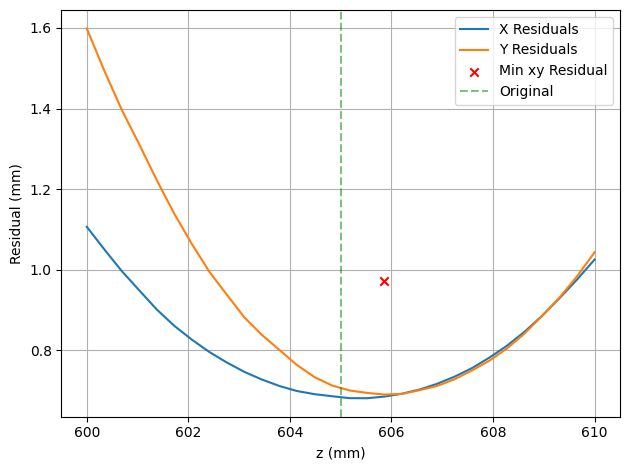

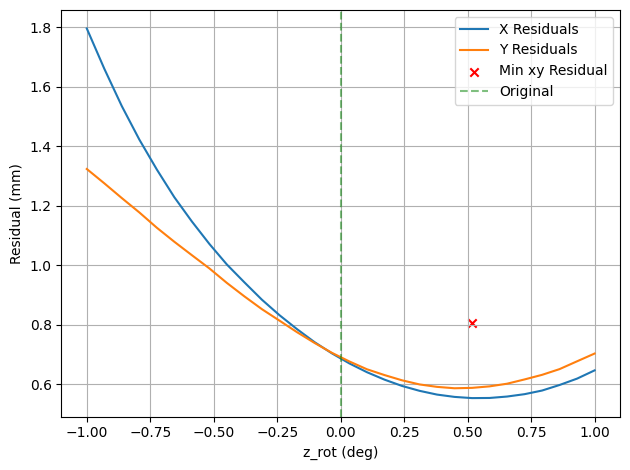

In [15]:
z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

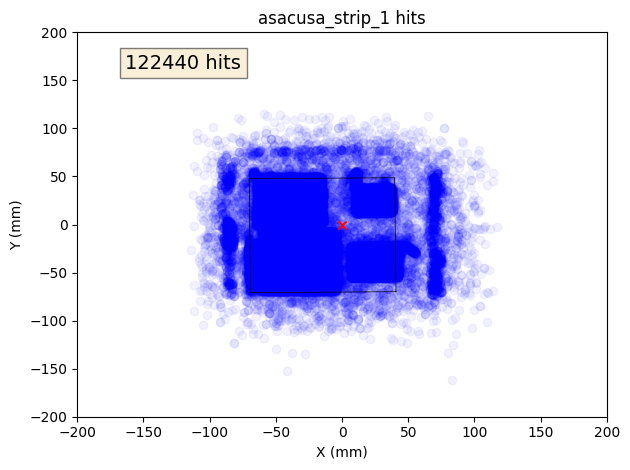

In [16]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 1630227
All rays: 374663


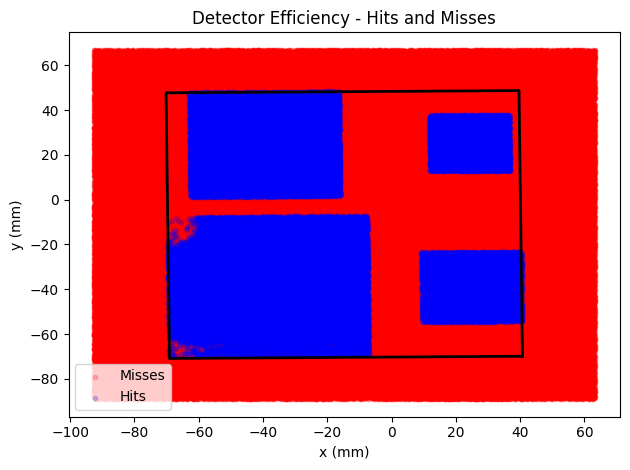

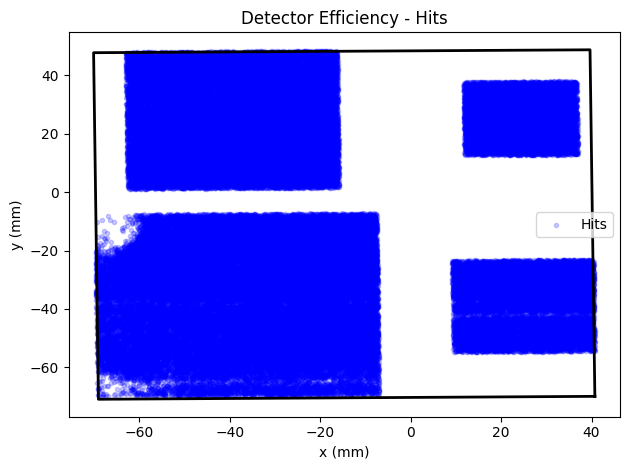

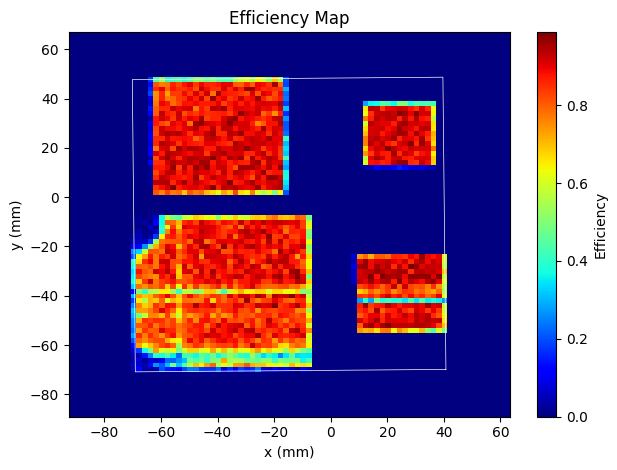

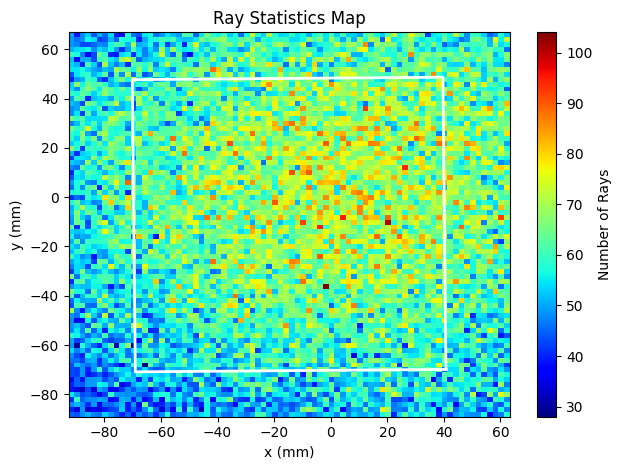

In [17]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=2)

/home/dylan/PycharmProjects/saclay_micromegas/poc/det_classes_test.py:1488: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


X Residuals: Mean=-8μm, Std=682μm
Y Residuals: Mean=6μm, Std=720μm
X Residuals: Mean=4μm, Std=400μm
Y Residuals: Mean=39μm, Std=472μm
X Residuals: Mean=22μm, Std=415μm
Y Residuals: Mean=-33μm, Std=422μm
X Residuals: Mean=3μm, Std=540μm
Y Residuals: Mean=-4μm, Std=550μm


(0.007477546196948842,
 -0.0016470935452079264,
 0.501846921950862,
 0.5576588329316188)

/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


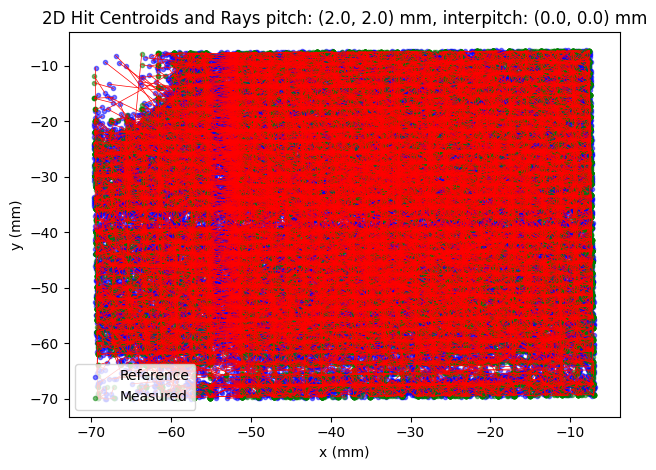

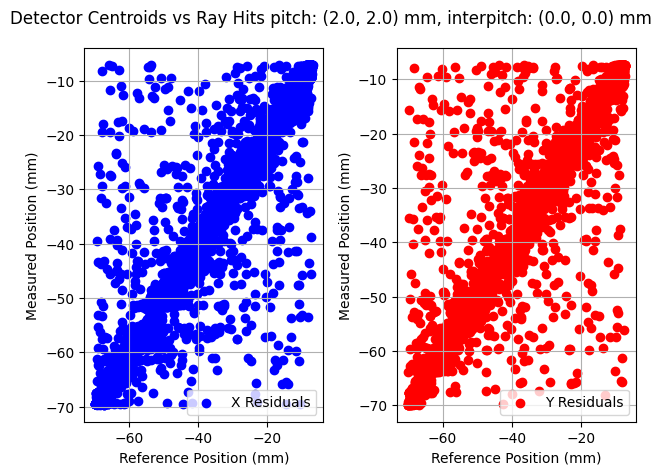

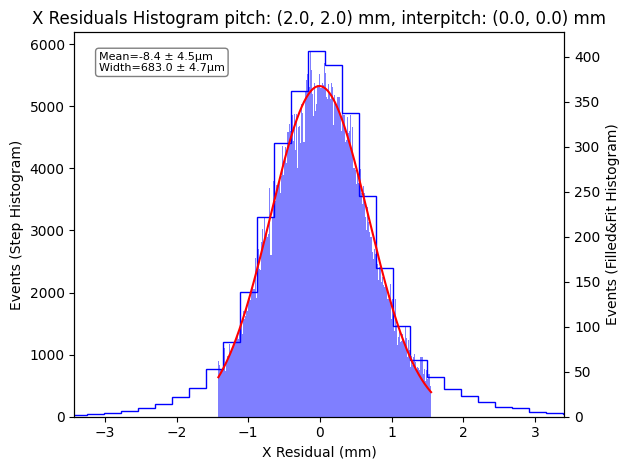

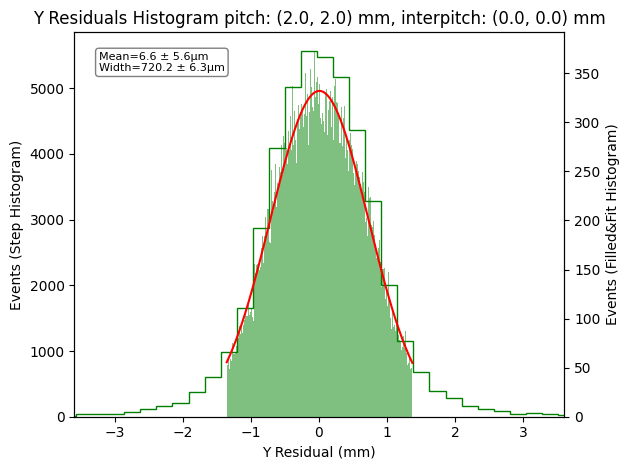

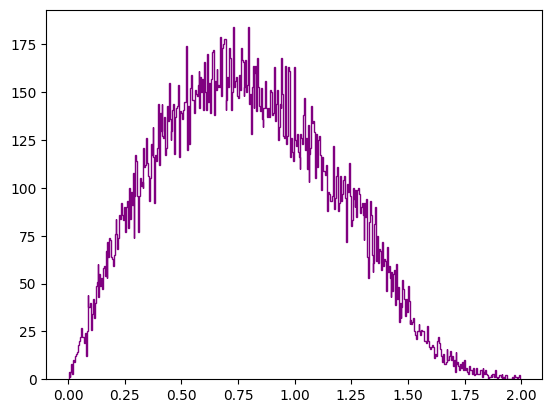

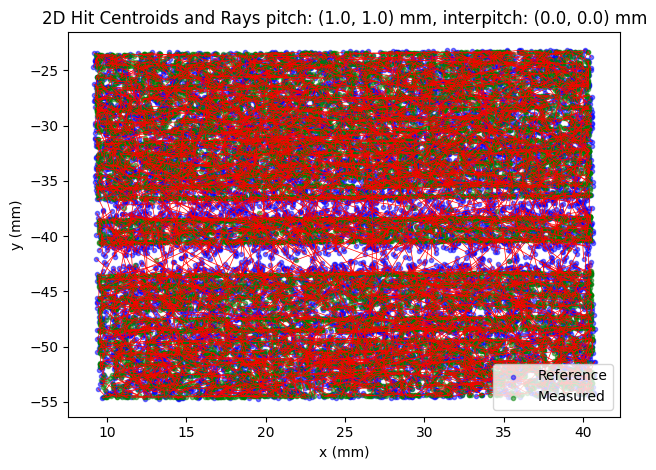

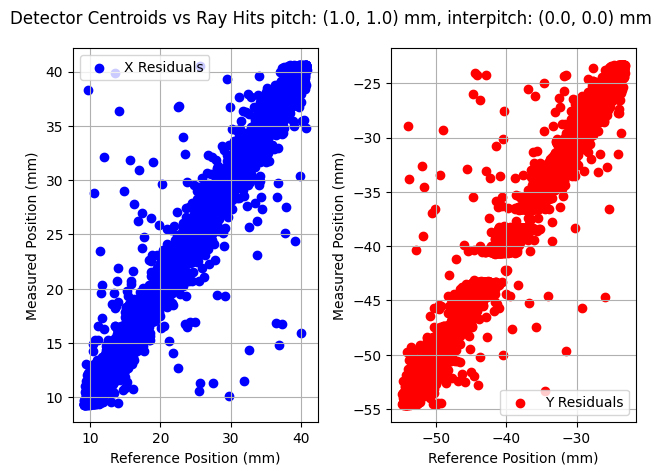

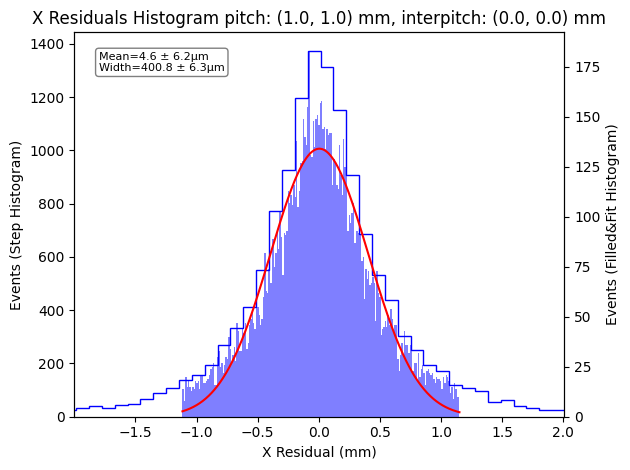

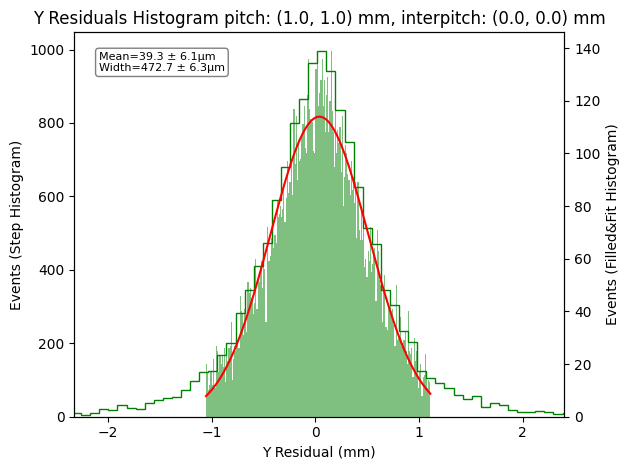

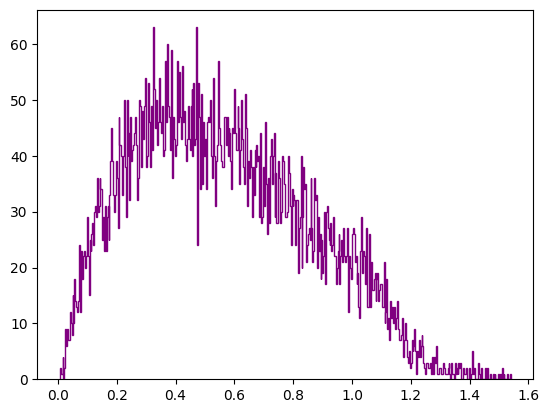

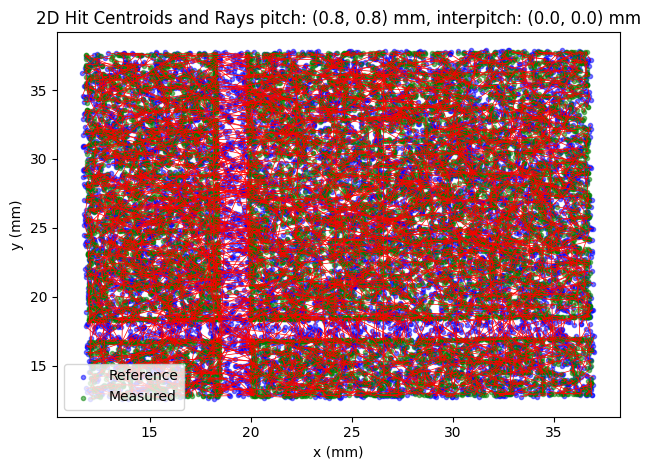

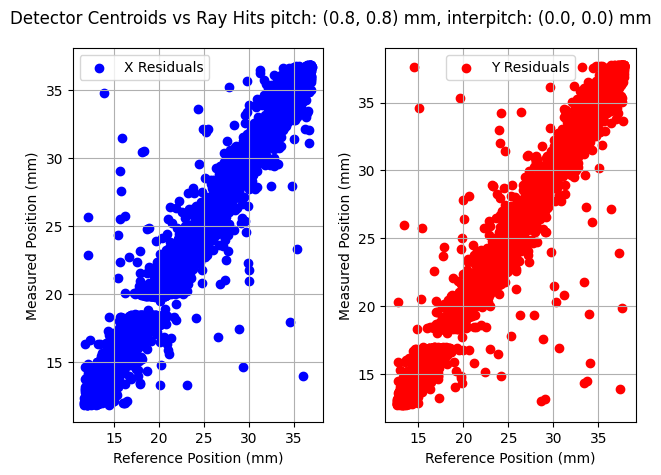

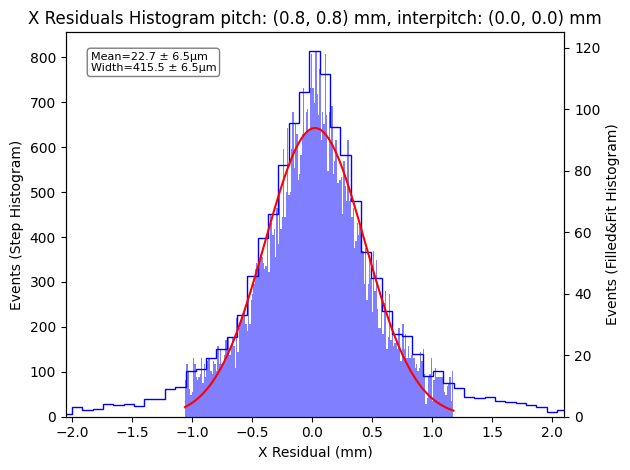

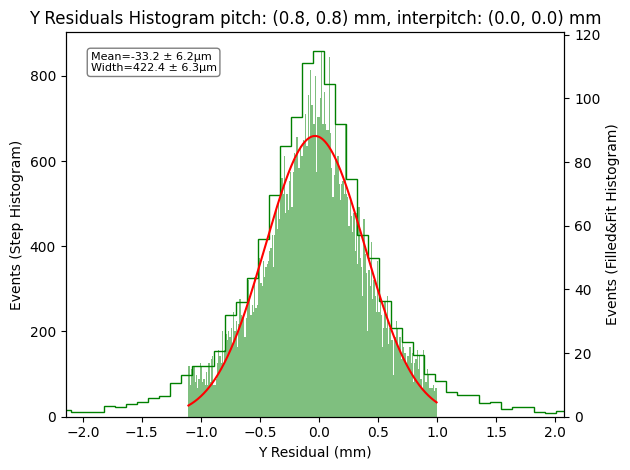

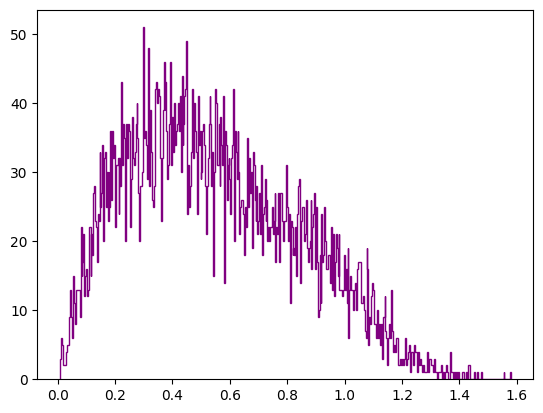

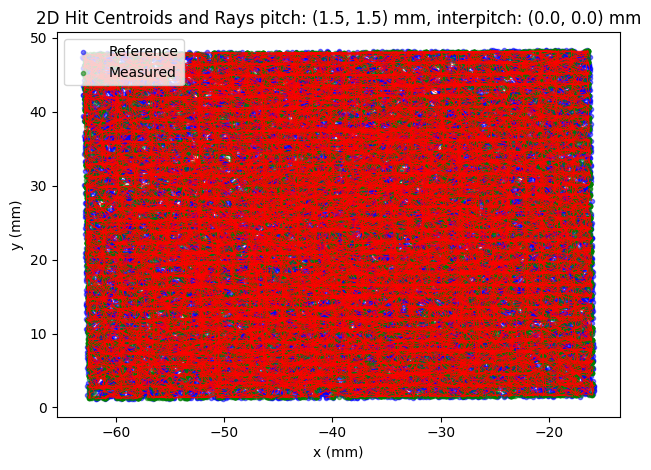

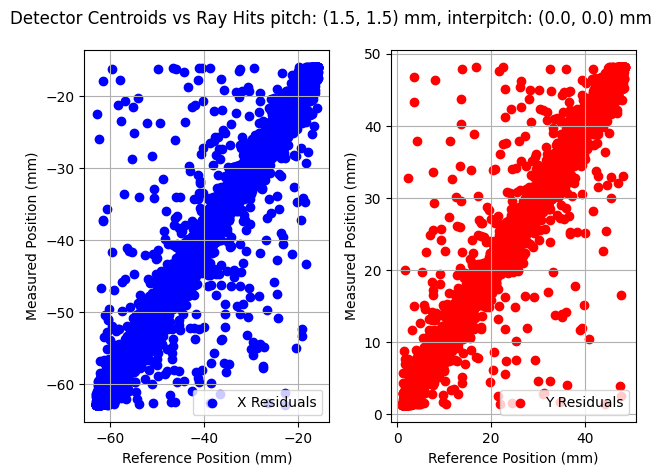

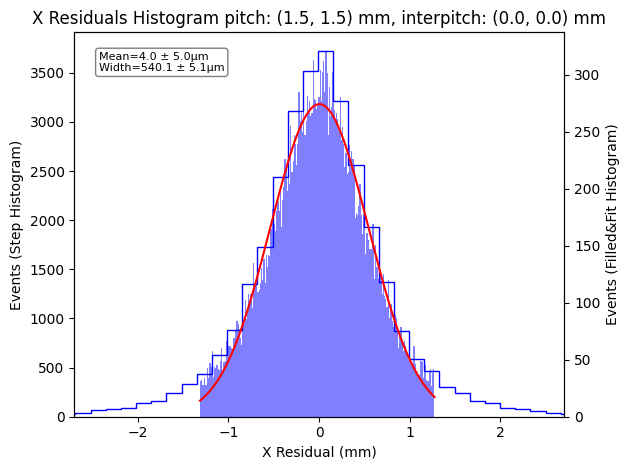

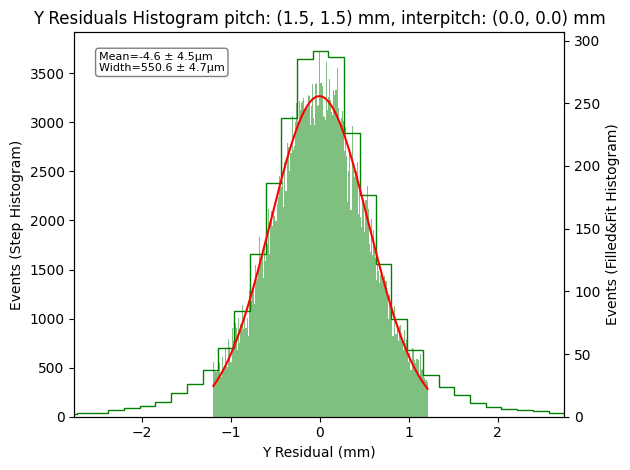

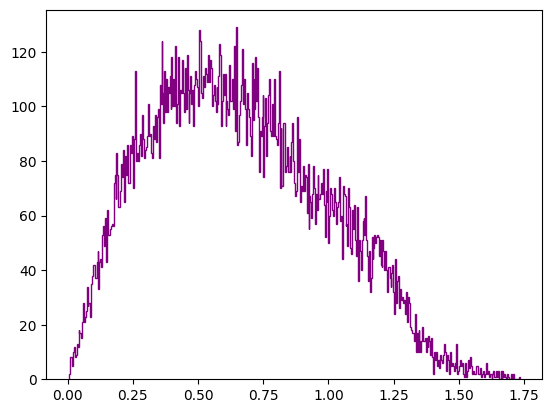

In [18]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [19]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      2.0      2.0           0.0           0.0 -0.008428    0.004476   
1      1.0      1.0           0.0           0.0  0.004585    0.006228   
2      0.8      0.8           0.0           0.0  0.022747    0.006455   
3      1.5      1.5           0.0           0.0  0.003975    0.004978   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.720239    0.006292  0.682952   0.004714  0.720239   0.006292  
1  0.472680    0.006268  0.400806   0.006253  0.472680   0.006268  
2  0.422448    0.006341  0.415473   0.006505  0.422448   0.006341  
3  0.550622    0.004685  0.540059   0.005099  0.550622   0.004685  


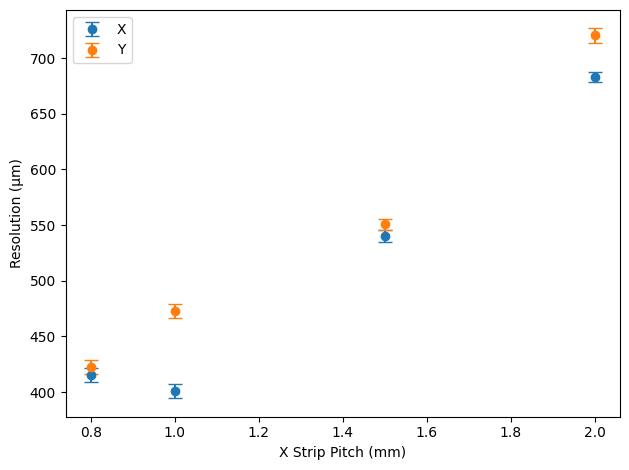

In [20]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['pitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['pitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Pitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      2.0      2.0           0.0           0.0 -0.009441    0.004940   
1      1.0      1.0           0.0           0.0  0.003349    0.005579   
2      0.8      0.8           0.0           0.0  0.023056    0.006104   
3      1.5      1.5           0.0           0.0  0.005493    0.004823   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.718147    0.007683  0.663293   0.005839  0.718147   0.007683  
1  0.459076    0.006612  0.386514   0.005693  0.459076   0.006612  
2  0.406356    0.006406  0.399903   0.006275  0.406356   0.006406  
3  0.535246    0.005449  0.519158   0.005260  0.535246   0.005449  


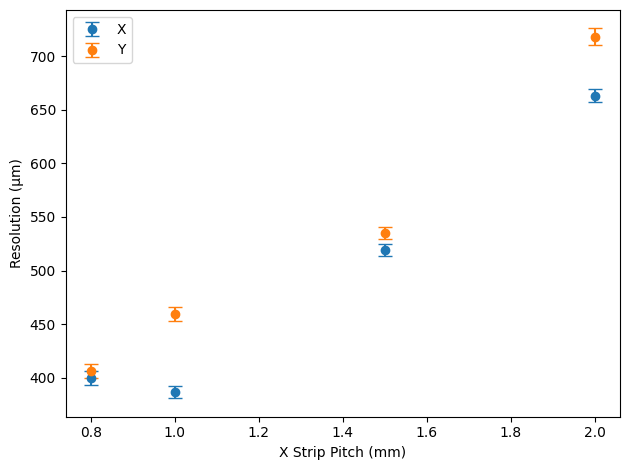

In [21]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['pitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['pitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Pitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      2.0      2.0           0.0           0.0 -0.009441    0.004940   
1      1.0      1.0           0.0           0.0  0.003349    0.005579   
2      0.8      0.8           0.0           0.0  0.023056    0.006104   
3      1.5      1.5           0.0           0.0  0.005493    0.004823   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.718147    0.007683  0.663293   0.005839  0.718147   0.007683  
1  0.459076    0.006612  0.386514   0.005693  0.459076   0.006612  
2  0.406356    0.006406  0.399903   0.006275  0.406356   0.006406  
3  0.535246    0.005449  0.519158   0.005260  0.535246   0.005449  


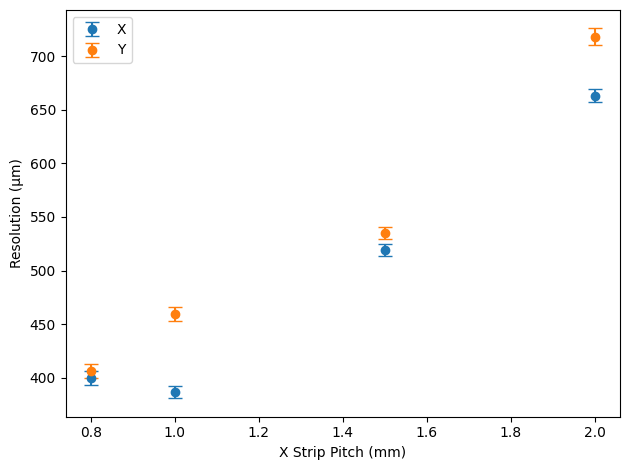

In [22]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['pitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['pitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Pitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

Rays in sub-detector 0: 52120, total rays: 1630227
Rays in sub-detector 1: 11827, total rays: 1630227
Rays in sub-detector 2: 7540, total rays: 1630227
Rays in sub-detector 3: 29548, total rays: 1630227


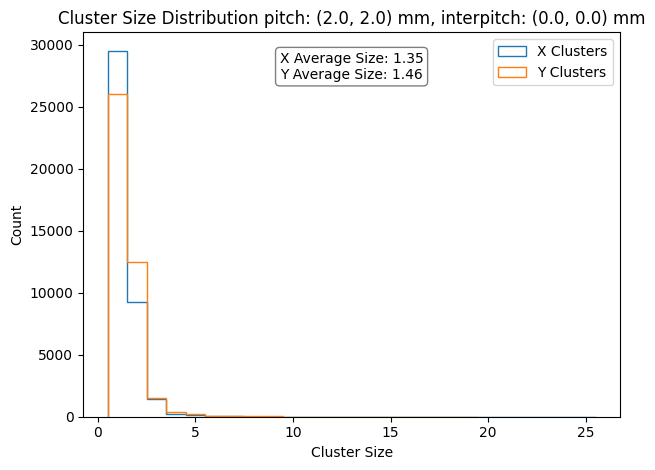

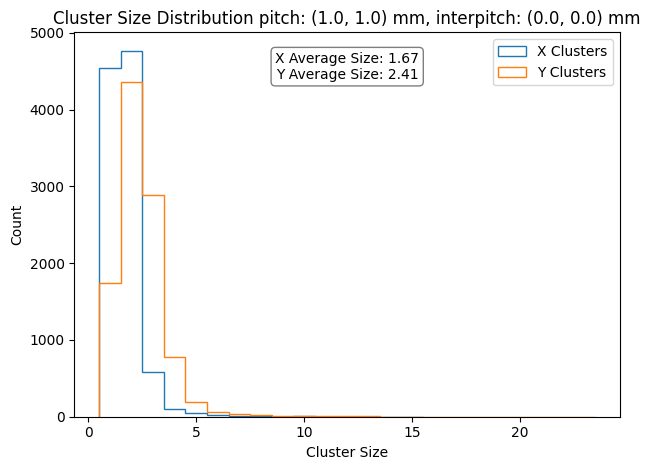

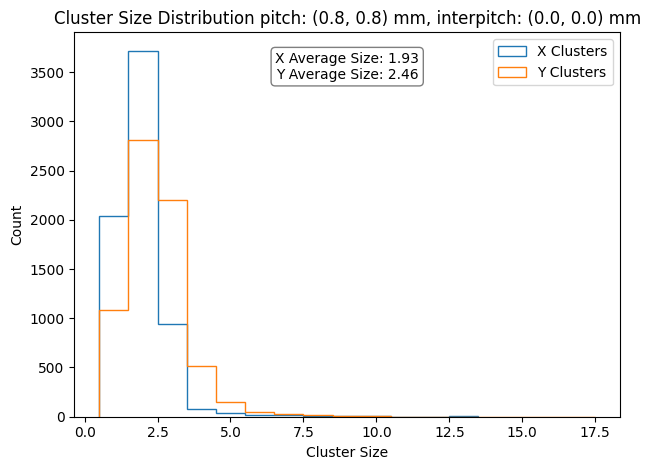

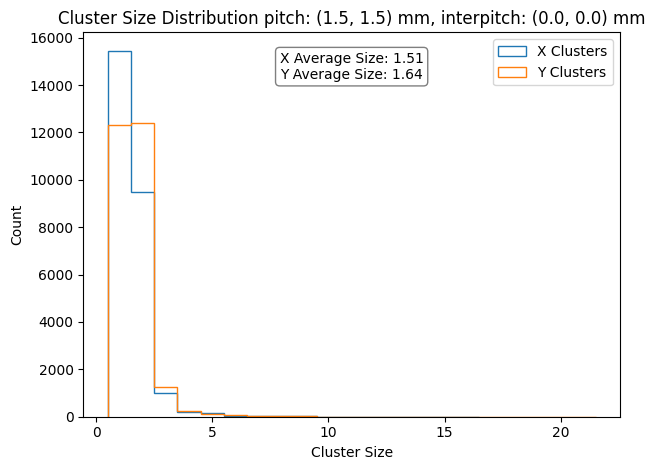

In [23]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_pitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

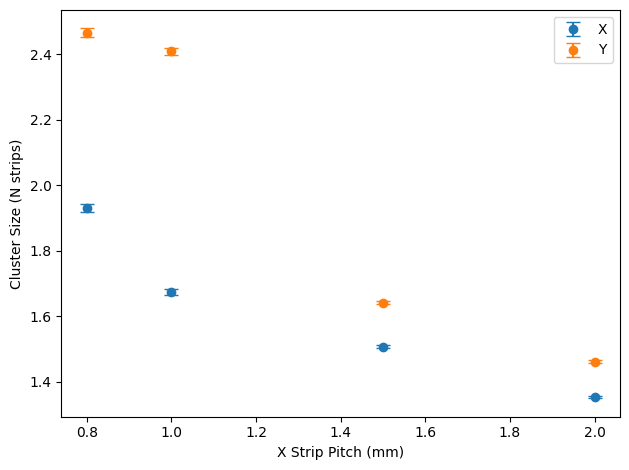

In [24]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Pitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

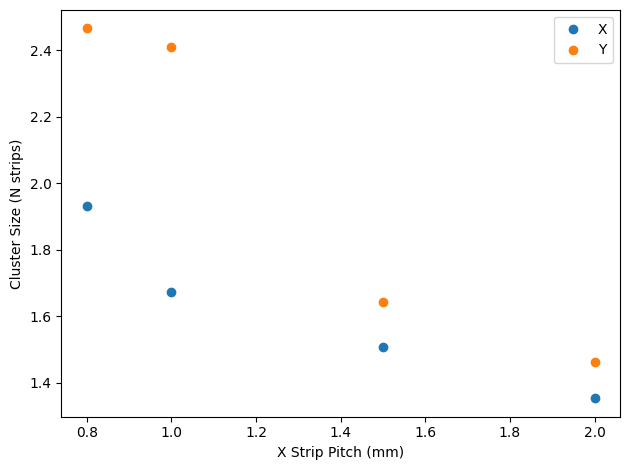

In [25]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Pitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

scan_res min: 160.50005542494628, max: 3777.2830475075216
res_vmax: 1609.127393360607
mean_vmin: -287.8536836570614, mean_vmax: 602.341750407047


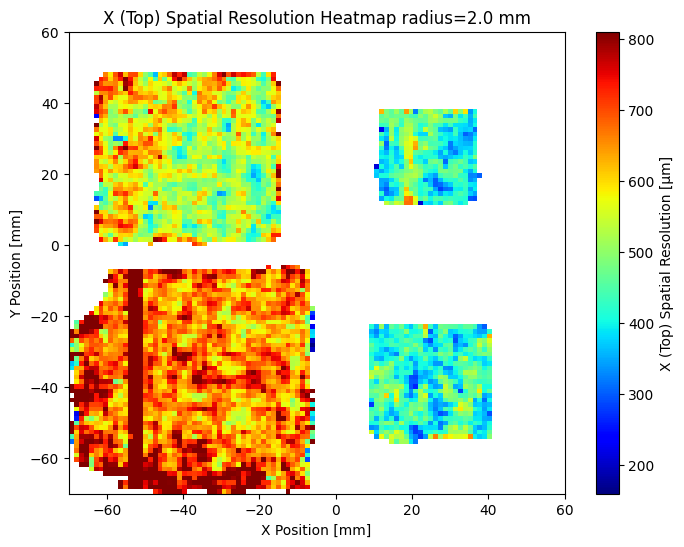

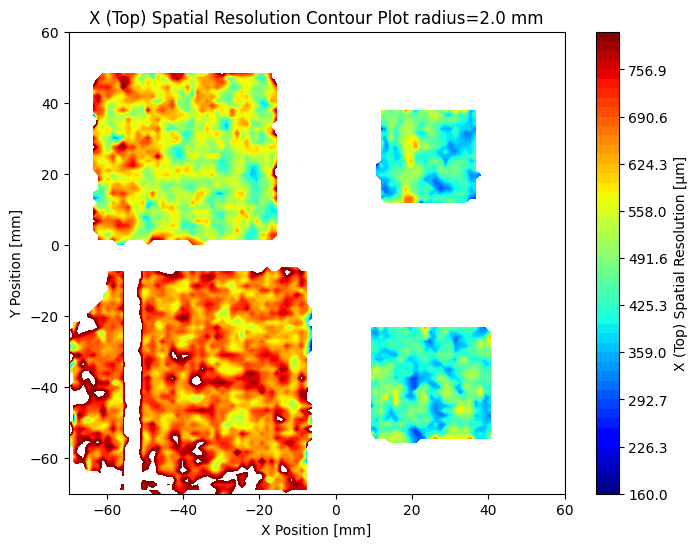

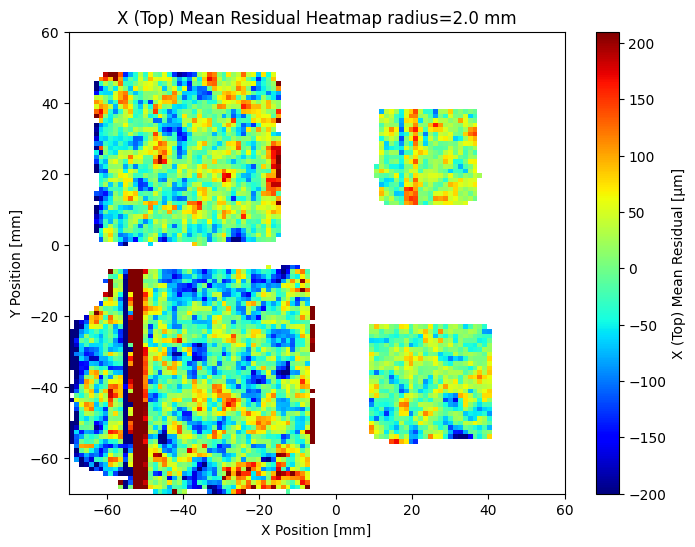

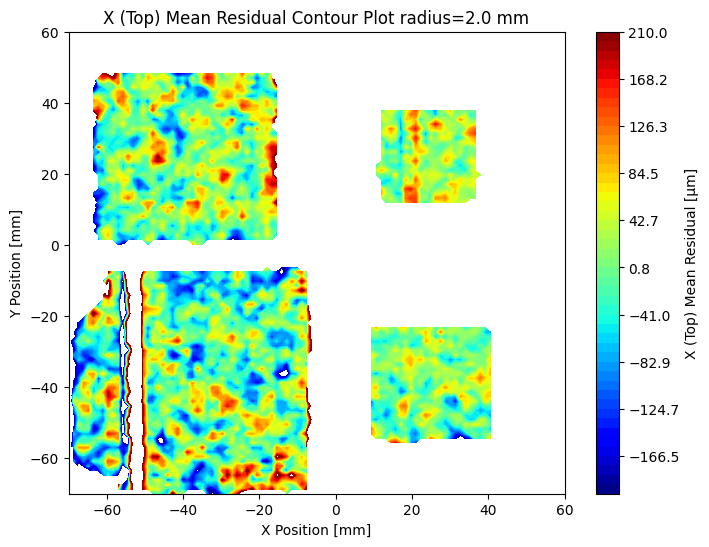

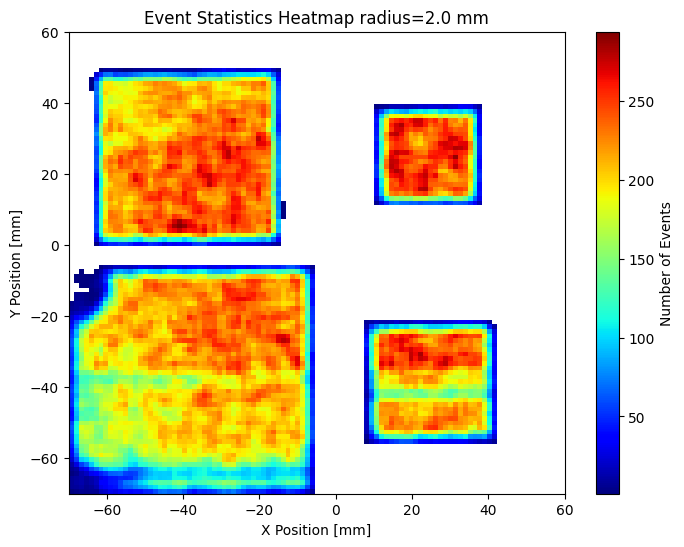

In [26]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)
scan_xs = np.linspace(-70, 60, 100 + 1)
scan_ys = np.linspace(-70, 60, 100 + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 2
min_events = 50
res_range = [160, 810]  # μm
mean_range = [-200, 210]  # μm

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='X (Top) Spatial Resolution', mean_title='X (Top) Mean Residual', res_range=res_range, mean_range=mean_range)

scan_res min: 224.92747811414802, max: 11279.603105768918
res_vmax: 1042.3187915331894
mean_vmin: -361.2661172126056, mean_vmax: 201.54899999902716


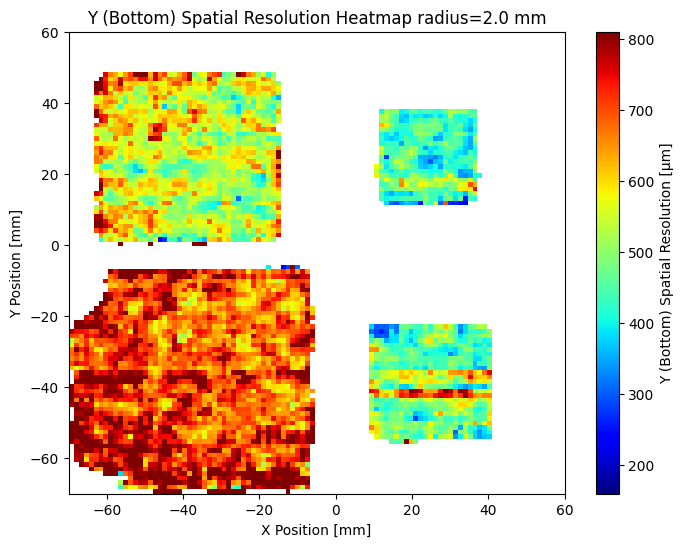

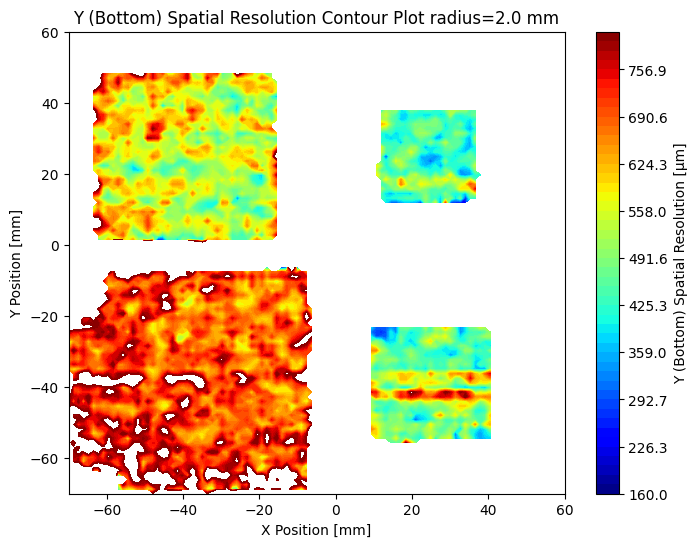

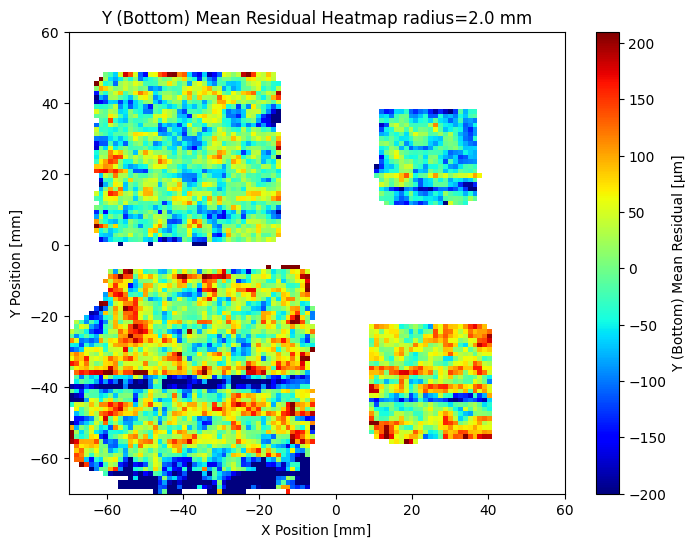

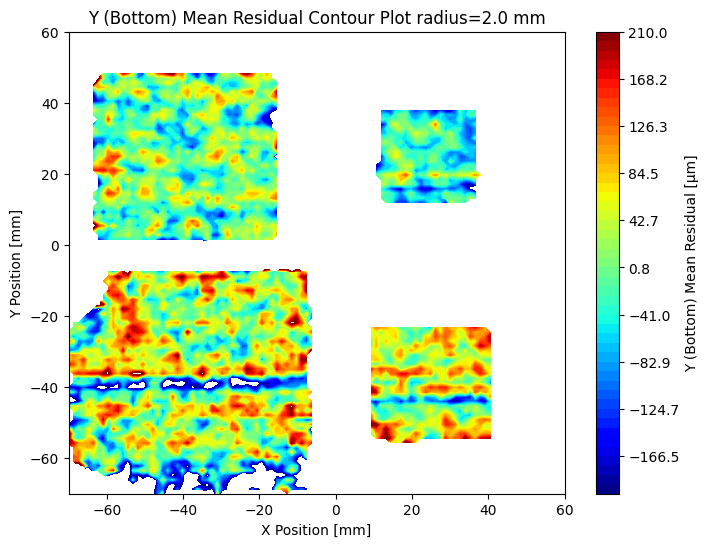

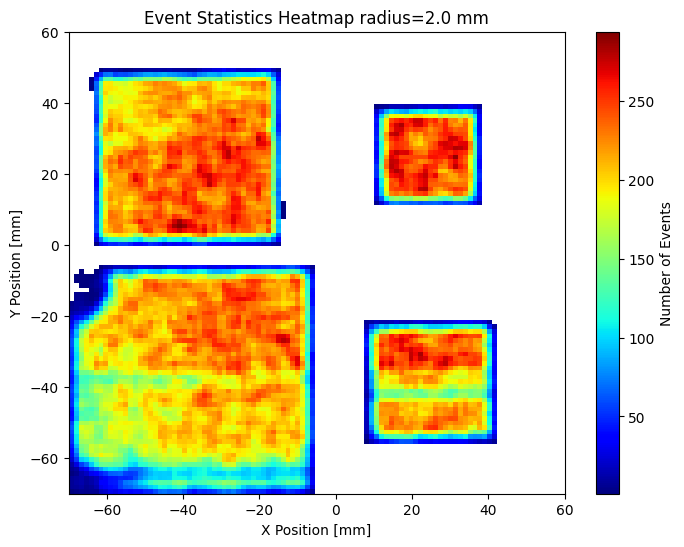

In [27]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='Y (Bottom) Spatial Resolution', mean_title='Y (Bottom) Mean Residual', res_range=res_range, mean_range=mean_range)

scan_res min: 664.0, max: 2174.0
res_vmax: 1778.75
mean_vmin: 1.3146627079816735, mean_vmax: 1.9588381502890173


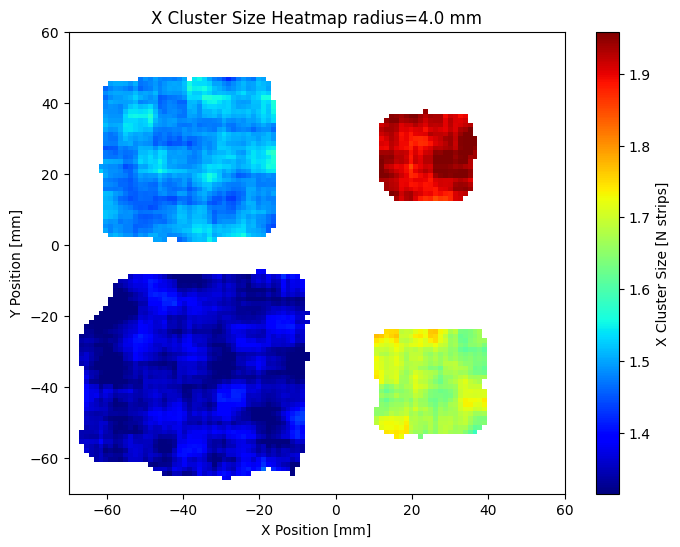

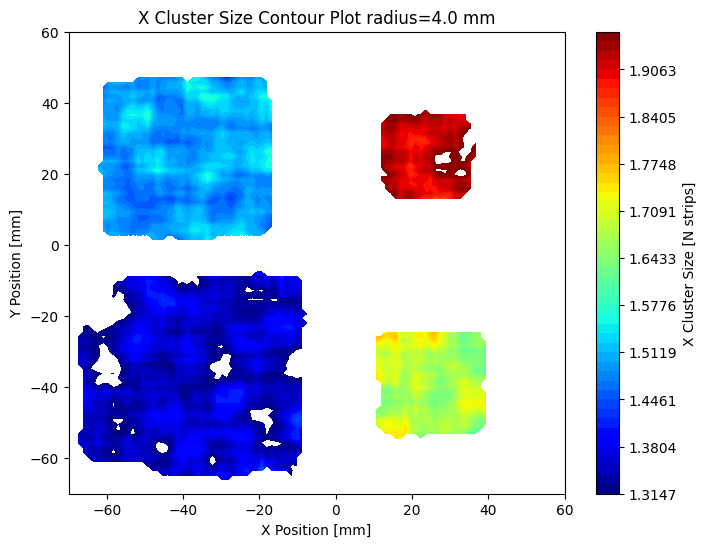

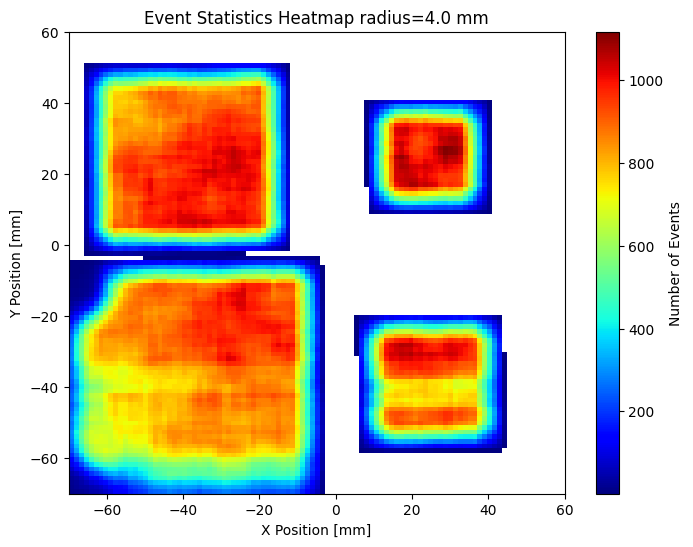

In [28]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)
scan_xs = np.linspace(-70, 60, 100 + 1)
scan_ys = np.linspace(-70, 60, 100 + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 4
min_events = 50
res_range = [160, 810]  # μm
mean_range = [-200, 210]  # μm

x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_sizes_all, y_sizes_all, x_rays_cluster_sizes, y_rays_cluster_sizes = [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=0)
    x_sizes, y_sizes, ray_mask = sub_det.get_cluster_sizes(largest=True, event_nums=event_num_rays_in, return_ray_mask=True)
    x_sizes_all.extend(x_sizes)
    y_sizes_all.extend(y_sizes)
    x_rays_cluster_sizes.extend(x_rays_in[ray_mask])
    y_rays_cluster_sizes.extend(y_rays_in[ray_mask])
scan_resolutions_csx, scan_means_csx, events_csx = get_circle_scan(np.array(x_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, shape='square', gaus_fit=False, min_events=500, plot=False)
plot_2D_circle_scan(scan_resolutions_csx, scan_means_csx, scan_xs, scan_ys, scan_events=events_csx, radius=scan_radius, percentile_filter=(1, 95), plot='mean', unit_str='N strips', mean_title='X Cluster Size')

scan_res min: 200.0, max: 2515.0
res_vmax: 2301.2000000000007
mean_vmin: 2.0, mean_vmax: 2.7146750524109016


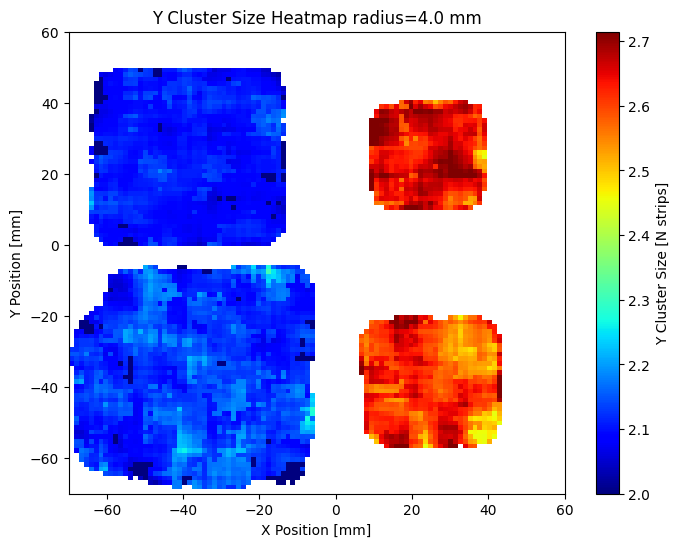

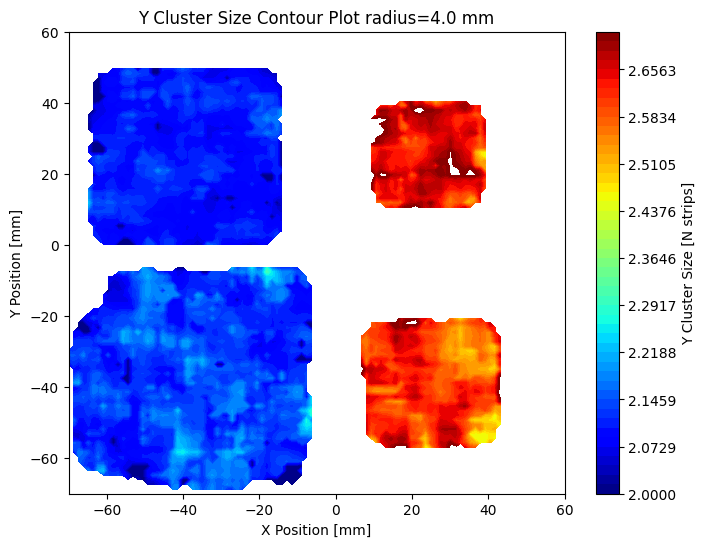

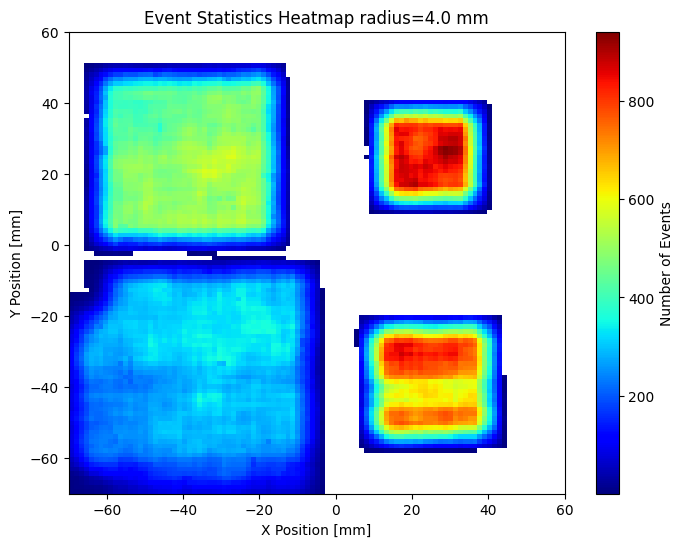

In [29]:
scan_resolutions_csy, scan_means_csy, events_csy = get_circle_scan(np.array(y_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), shape='square', gaus_fit=False, plot=False)
plot_2D_circle_scan(scan_resolutions_csy, scan_means_csy, scan_xs, scan_ys, scan_events=events_csy, radius=scan_radius, percentile_filter=(1, 99), plot='mean', unit_str='N strips', mean_title='Y Cluster Size')

Text(0.5, 1.0, 'Time of Max for Y (Bottom) Strips')

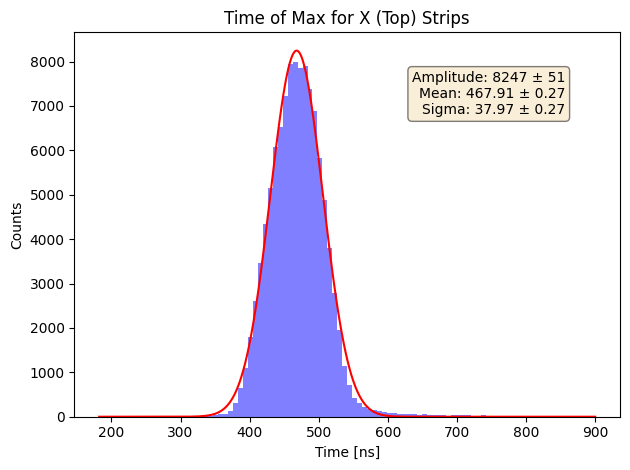

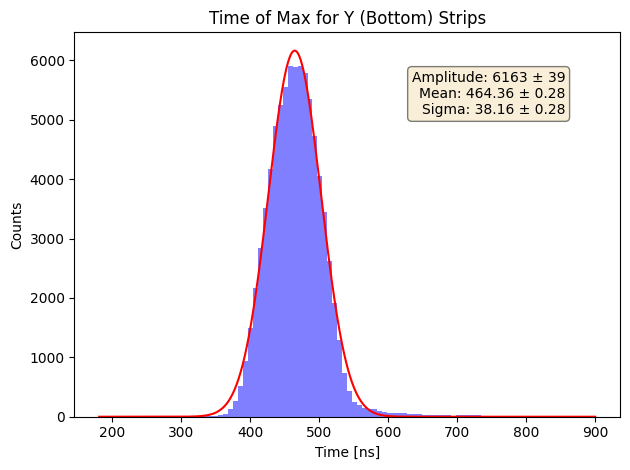

In [30]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

Text(0.5, 1.0, 'Time of Max for Y (Bottom) Strips')

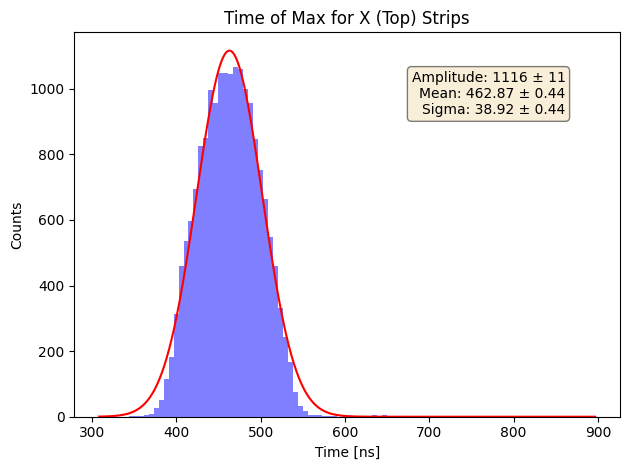

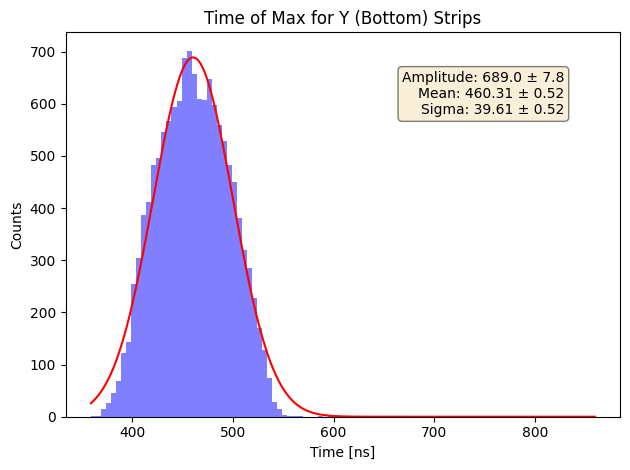

In [31]:
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=600, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=600, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

In [32]:
x_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=None, min_amp=None, filter_times=False)
x_time_maxes, x_time_filter = det.dream_data.filter_time_maxes(x_time_maxes, return_mask=True)
y_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, filter_times=False)
y_time_maxes, y_time_filter = det.dream_data.filter_time_maxes(y_time_maxes, return_mask=True)
time_ray_event_mask_x = np.isin(event_num_rays, det.dream_data.event_nums[x_time_filter])
time_ray_event_mask_y = np.isin(event_num_rays, det.dream_data.event_nums[y_time_filter])
x_rays_timing_x, y_rays_timing_x = x_rays[time_ray_event_mask_x], y_rays[time_ray_event_mask_x]
x_rays_timing_y, y_rays_timing_y = x_rays[time_ray_event_mask_y], y_rays[time_ray_event_mask_y]

scan_res min: 25.963802977119478, max: 72.21907677769794
res_vmax: 50.3908907806136
mean_vmin: 456.61636555169065, mean_vmax: 474.5993804219381


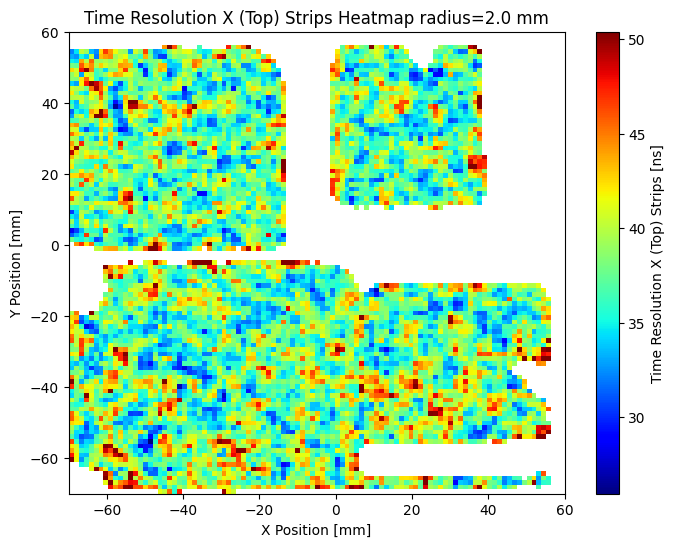

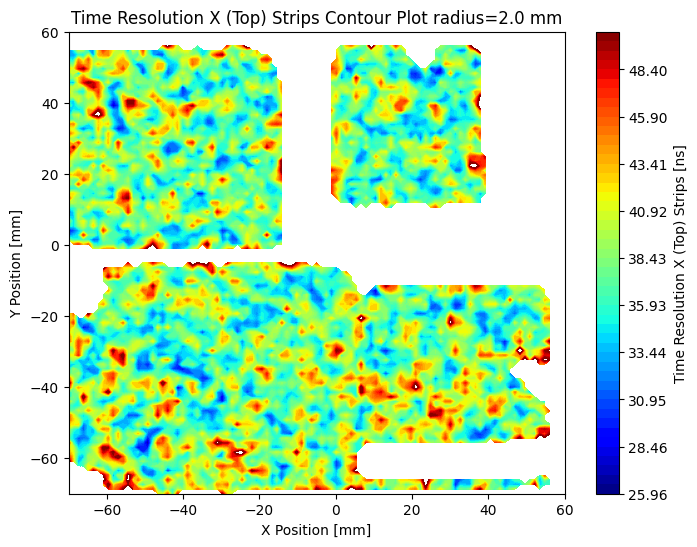

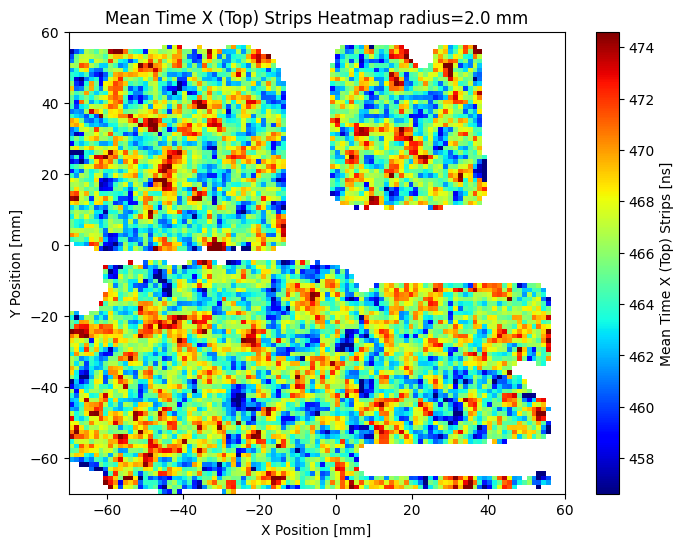

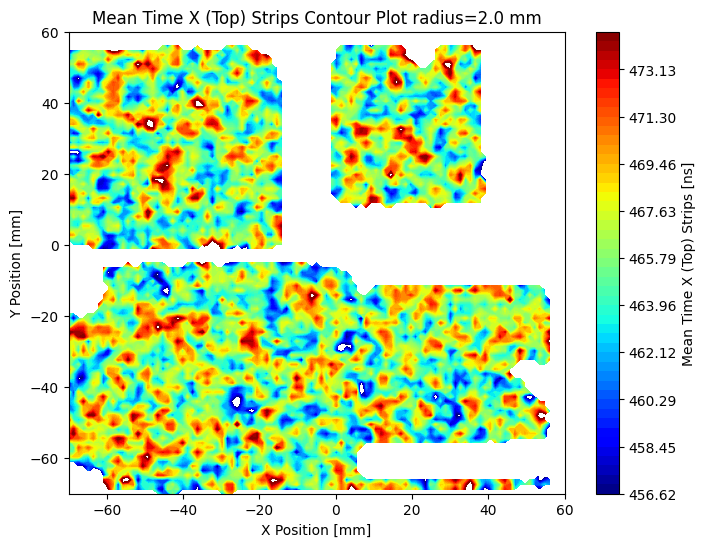

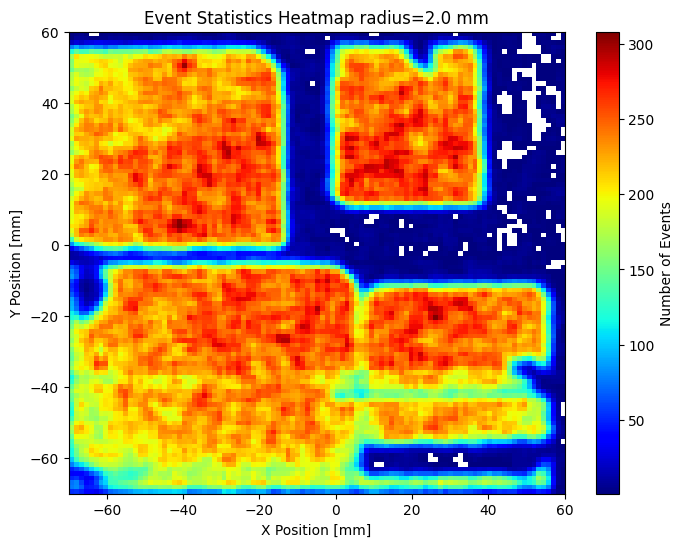

In [33]:
scan_radius = 2
min_events = 100
res_range = None  # ns
mean_range = None  # ns
scan_time_resolutions_x, scan_time_means_x, events_time_x = get_circle_scan(np.array(x_time_maxes), np.array(x_rays_timing_x), np.array(y_rays_timing_x), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_x, scan_time_means_x, scan_xs, scan_ys, scan_events=events_time_x, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution X (Top) Strips', mean_title='Mean Time X (Top) Strips', res_range=res_range, mean_range=mean_range)

scan_res min: 27.088716497103785, max: 62.95404626740697
res_vmax: 50.63719080248029
mean_vmin: 455.26312144369393, mean_vmax: 472.0203930445105


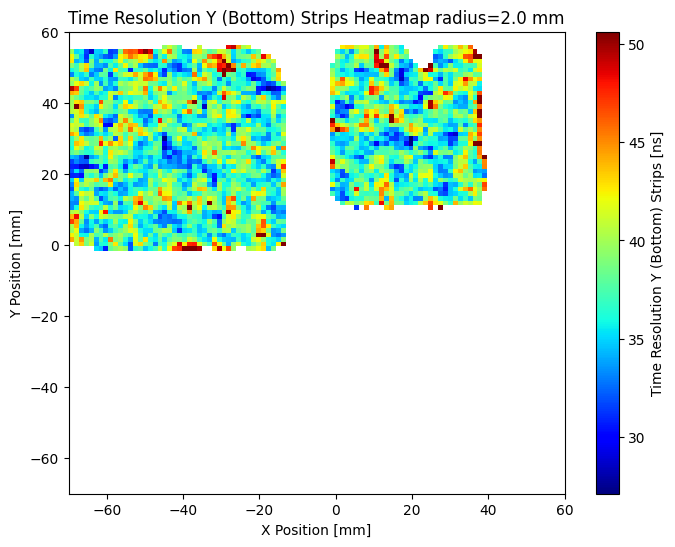

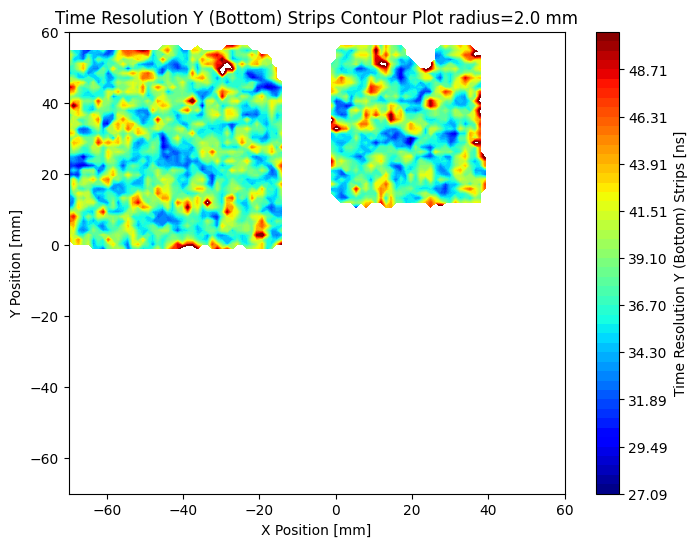

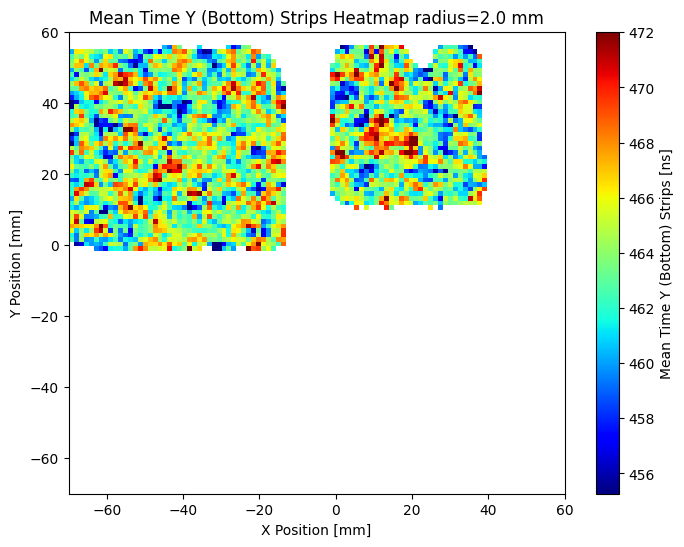

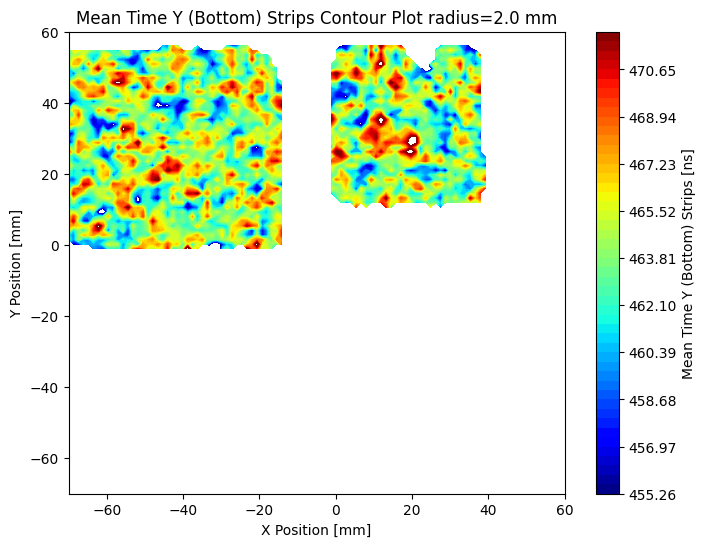

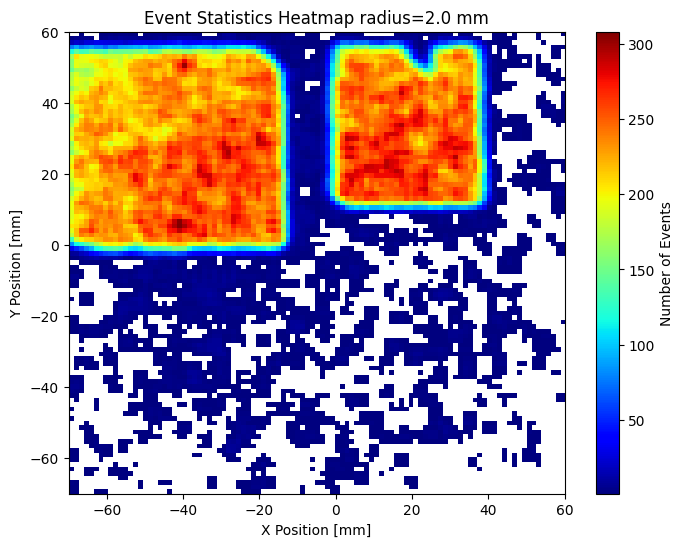

In [34]:
scan_time_resolutions_y, scan_time_means_y, events_time_y = get_circle_scan(np.array(y_time_maxes), np.array(x_rays_timing_y), np.array(y_rays_timing_y), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_y, scan_time_means_y, scan_xs, scan_ys, scan_events=events_time_y, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution Y (Bottom) Strips', mean_title='Mean Time Y (Bottom) Strips', res_range=res_range, mean_range=mean_range)

In [35]:
edge_cushion = 5 # mm
det_z = det.center[2]
for sub_det in det.sub_detectors:
    x_min_loc, x_max_loc = np.min(sub_det.x_pos), np.max(sub_det.x_pos)
    y_min_loc, y_max_loc = np.min(sub_det.y_pos), np.max(sub_det.y_pos)
    top_left, top_right = (x_min_loc, y_max_loc, det_z), (x_max_loc, y_max_loc, det_z)
    bottom_left, bottom_right = (x_min_loc, y_min_loc, det_z), (x_max_loc, y_min_loc, det_z)
    top_left, top_right = det.convert_coords_to_global(top_left), det.convert_coords_to_global(top_right)
    bottom_left, bottom_right = det.convert_coords_to_global(bottom_left), det.convert_coords_to_global(bottom_right)
    print(f'Sub-detector {sub_det.sub_index} corners:')
    print(f'Top Left: {top_left}, Top Right: {top_right}, Bottom Left: {bottom_left}, Bottom Right: {bottom_right}')


Sub-detector 0 corners:
Top Left: [ -69.09379557  -69.89568083 1209.72413793], Top Right: [ -69.65349701   -7.89820722 1209.72413793], Bottom Left: [  -7.09632196  -69.3359794  1209.72413793], Bottom Right: [  -7.65602339   -7.33850579 1209.72413793]
Sub-detector 1 corners:
Top Left: [   9.60232696  -54.59963283 1209.72413793], Top Right: [   9.32247624  -23.60089602 1209.72413793], Bottom Left: [  40.60106376  -54.31978211 1209.72413793], Bottom Right: [  40.32121305  -23.3210453  1209.72413793]
Sub-detector 2 corners:
Top Left: [  12.06351961   12.74032943 1209.72413793], Top Right: [  11.83963904   37.53931888 1209.72413793], Bottom Left: [  36.86250906   12.96421    1209.72413793], Bottom Right: [  36.63862848   37.76319945 1209.72413793]
Sub-detector 3 corners:
Top Left: [ -62.47989727    1.2619253  1209.72413793], Top Right: [ -62.89967334   47.76003051 1209.72413793], Bottom Left: [ -15.98179206    1.68170137 1209.72413793], Bottom Right: [ -16.40156813   48.17980658 1209.724137